# Building A Music Recommendation Engine

## Importing pakages 

In [96]:
#Packages for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import os
from datetime import datetime
import missingno as msno
from scipy import stats

#Packages for splitting data
from sklearn import base
from sklearn.model_selection import KFold

#Packages for controlling figure size
from IPython.core.pylabtools import figsize


In [97]:
#Getting Working Directory
os.getcwd()

#Setting style and font size for graphs
sns.set_style("whitegrid")
mpl.rcParams['font.size'] = 13

## Importing Data from the CSV file 

In [98]:
#Setting the file path
train_file ='D:\\Abhishek\\Personal\\Springboard\\music_recom\\train.csv'
test_file ='D:\\Abhishek\\Personal\\Springboard\\music_recom\\test.csv'
songs_file ='D:\\Abhishek\\Personal\\Springboard\\music_recom\\songs.csv'
members_file ='D:\\Abhishek\\Personal\\Springboard\\music_recom\\members.csv'
songs_ex_file ='D:\\Abhishek\\Personal\\Springboard\\music_recom\\song_extra_info.csv'

#Reading the csv file to pandas dataframe
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)
songs = pd.read_csv(songs_file)
members = pd.read_csv(members_file)
songs_ex = pd.read_csv(songs_ex_file)

## Understanding the Data. 
Number of columns, whether it was imported correctly, number of missing values etc.

In [99]:
#Check shape of the dataset and number of columns
print("Train Shape", train.shape)
print("Test Shape", test.shape)
print("Songs Shape", songs.shape)
print("Members Shape", members.shape)
print("songs_extra_info Shape", songs_ex.shape)

Train Shape (7377418, 6)
Test Shape (2556790, 6)
Songs Shape (2296320, 7)
Members Shape (34403, 7)
songs_extra_info Shape (2295971, 3)


In [100]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


## Data Pre-Processing
- Transformation and merging tables: The information and features are present in different tables. Thus there is a need for merging into one table. Also there is a need for transforming columns to its right data types.
- Missing Value Analysis: We need to look for any missing values and clean our dataset
- Outliers: Check if any outliers present

### Merging different dataset into one table

In [101]:
#Creating the master table having songs and members info from the respective tables

#training data set
train = train.merge(songs, how = 'left', on = 'song_id')
train = train.merge(members, how = 'left', on = 'msno')
train = train.merge(songs_ex, how = 'left', on = 'song_id')

#testing data set
test = test.merge(songs, how = 'left', on = 'song_id')
test = test.merge(members, how = 'left', on = 'msno')
test = test.merge(songs_ex, how = 'left', on = 'song_id')

print("Training Data Shape:", train.shape)
print("Testing Data Shape:", test.shape)

#Checking for the column names and their data types
train.info()

Training Data Shape: (7377418, 20)
Testing Data Shape: (2556790, 20)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 20 columns):
msno                      object
song_id                   object
source_system_tab         object
source_screen_name        object
source_type               object
target                    int64
song_length               float64
genre_ids                 object
artist_name               object
composer                  object
lyricist                  object
language                  float64
city                      int64
bd                        int64
gender                    object
registered_via            int64
registration_init_time    int64
expiration_date           int64
name                      object
isrc                      object
dtypes: float64(2), int64(6), object(12)
memory usage: 1.2+ GB


#### We see that our date columns are of integer type and those needs transformation to a datetime type.

In [102]:
#Converting integer time columns to string so that converting to date becomes easy

#Function to convert date columns to date format
def timeconvert(data,collist):
    
    for col in collist:
        data[col] = data[col].astype('str')
        data[col] = pd.to_datetime(data[col], infer_datetime_format = True)
    
    return data

#Date columns to transform
timecol = ['registration_init_time', 'expiration_date']

#Converting the columns
train = timeconvert(train, timecol)
test = timeconvert(test,timecol)
#train.info()

### Missing Value Analysis

#### Finding our features with missing value

In [103]:
# Function to calculate missing values
def missing_values(data):
    
    # Creating new dataframe to store features and their missing values
    m_table = pd.DataFrame(columns = ['feature_name', 'null_values', '%missing', 'category_count'])
    
    #Counting the missing values and appending it to m_table
    for col in data.columns:
        null_count = data[col].isnull().sum()
        missing = round((null_count/len(train))*100,2)
        count = len(data[col].unique())
        m_table = m_table.append(pd.Series([col, null_count, missing,count],index = m_table.columns),ignore_index=True)

    #Displaying features which has missing values in descending order
    missing = m_table[m_table.null_values != 0].sort_values(by = '%missing',ascending = False).reset_index(drop = True)
    display('Missing Value Table')
    display(missing)
    print('\n')

In [104]:
print('Train Data')
missing_values(train)

print('Test Data')
missing_values(test)

Train Data


'Missing Value Table'

,feature_name,null_values,%missing,category_count
0,lyricist,3178798,43.09,33889
1,gender,2961479,40.14,3
2,composer,1675706,22.71,76065
3,isrc,577858,7.83,269761
4,source_screen_name,414804,5.62,21
5,genre_ids,118455,1.61,573
6,source_system_tab,24849,0.34,9
7,source_type,21539,0.29,13
8,name,1457,0.02,234145
9,song_length,114,0.00,60267




Test Data


'Missing Value Table'

,feature_name,null_values,%missing,category_count
0,lyricist,1224744,16.60,24911
1,gender,1052224,14.26,3
2,composer,619304,8.39,52307
3,isrc,196643,2.67,170988
4,source_screen_name,162883,2.21,23
5,genre_ids,42110,0.57,502
6,source_system_tab,8442,0.11,9
7,source_type,7297,0.10,13
8,name,778,0.01,154717
9,song_length,25,0.00,45658


#### It is observed that some missing values are correlated with each other. Eg. Lyricist name and Composer. Artist Name and language, source system tab and source type. 

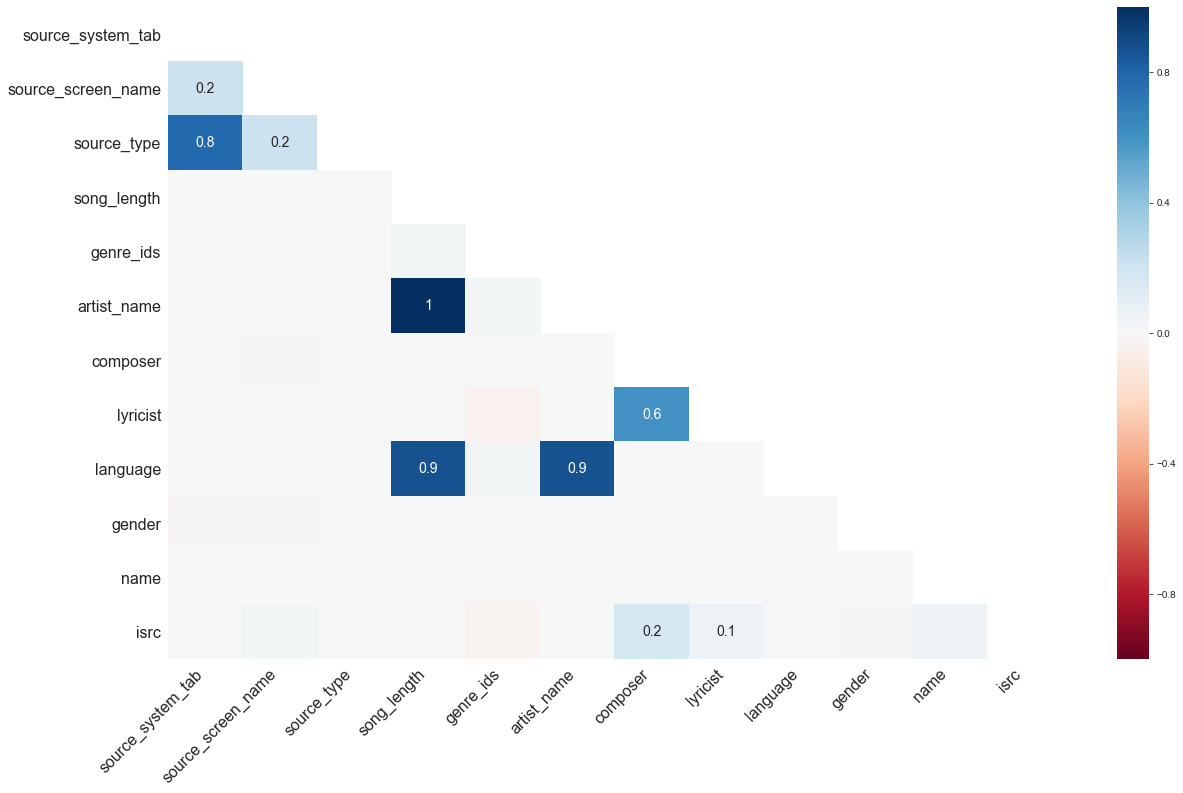

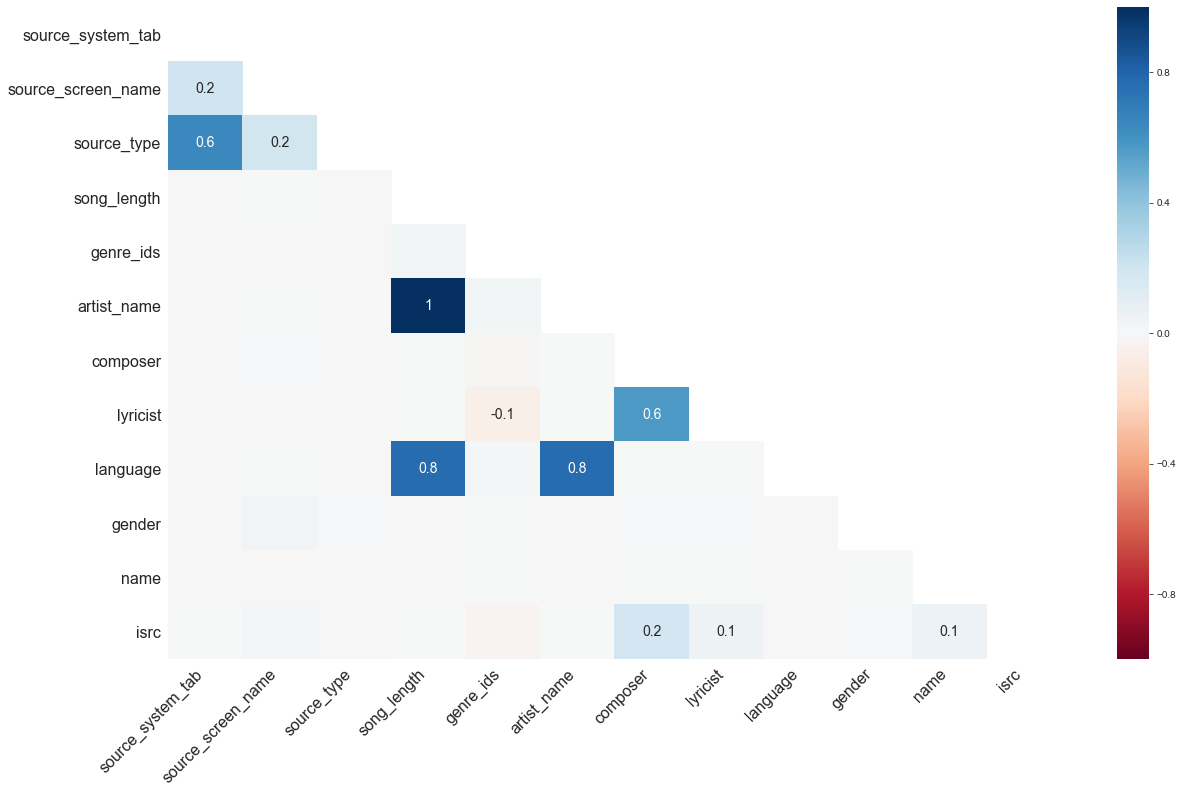

In [105]:
%matplotlib inline
#Understanding the correlation between different missing values
msno.heatmap(train)

msno.heatmap(test)

#### Replacing the missing values as per below criterias
- Lyricist is an important feature for this data set and if we remove all the rows with missing values, we might loose a lot of information. Thus it was decided to create a separate category of missing values. 

- Same logic is applied to all missing categorical variables except for song length

- For song length, missing values are replaced by median values. 

In [106]:
# List of Columns containing missing values
missing_cols = ['lyricist', 'gender', 'composer', 'source_screen_name', 'genre_ids', 'source_system_tab',
                'source_type', 'artist_name', 'name', 'isrc', 'language']

# Function to replace missing values with a "missing" category except for langauge. Song
def replace_missing(data,cols):
    
    for col in cols:
        
        # replace language missing values with -1
        if col == 'language':
            data[col].fillna(-1,inplace=True)
        
        # replace other categories
        else:
            data[col].fillna(col+"_missing",inplace=True)
    
    return data

train = replace_missing(train,missing_cols)

# performing the same transformation for test data set
test = replace_missing(test, missing_cols)

# Replacing song_length missing values using the median song length
median_song_length = train.song_length.median()
train.song_length.fillna(median_song_length, inplace = True)

# To prevent information leakage, replacing the song_length missing values 
# of test data set using median obtained from training set
test.song_length.fillna(median_song_length, inplace = True)

In [107]:
#Checking for missing_values
print('Train Data')
missing_values(train)

print('Test Data')
missing_values(test)

Train Data


'Missing Value Table'

,feature_name,null_values,%missing,category_count




Test Data


'Missing Value Table'

,feature_name,null_values,%missing,category_count


## New Feature Creation

### Count Features - Song Characteristics

In [108]:
# Names of lyricist, artist, composers, genre ids etc. are separated by few characters like |, / etc. 

# Counting the number of lyricist for a song
def lyricist_count(x):
    if x == 'lyricist_missing':
        return 0
    else:
        return sum(map(x.count, ['|', '/', '\\', ';']))+1

# Counting the number of artist  for a song    
def artist_count(x):
    if x == 'lyricist_missing':
        return 0
    else:
        return x.count('and') + x.count(',') + x.count('feat') + x.count('&') + x.count('|') + 1

# Counting the number of composer for a song
def composer_count(x):
    if x == 'composer_missing':
        return 0
    else:
        return sum(map(x.count, ['|', '/', '\\', ';']))+1

# Counting the number of genres of a song
def genre_id_count(x):
    if x == 'genre_missing':
        return 0
    else:
        return x.count('|') + 1
    


In [109]:
count_cols = ['lyricist', 'artist', 'composer', 'genre_ids']

# function to create count features
def count_categories(data):
    data['lyricist_count'] = data['lyricist'].apply(lyricist_count)
    data['artist_count'] = data['artist_name'].apply(artist_count)
    data['composer_count'] = data['composer'].apply(composer_count)
    data['genre_count'] = data['genre_ids'].apply(genre_id_count)
    
    return data

train = count_categories(train)
test = count_categories(test)
#train.info()

### Extracting country and year from isrc code

In [110]:
# Extracting country
train['isrc_country'] = train.isrc.apply(lambda x: x[:2] if x != 'isrc_missing' else 'country_missing')
test['isrc_country'] = test.isrc.apply(lambda x: x[:2] if x != 'isrc_missing' else 'country_missing')

# Function to convert isrc to year
def isrc_to_year(isrc):
    if isrc != 'isrc_missing':
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return -1

# Extracting isrc year
train['isrc_year'] = train.isrc.apply(isrc_to_year)
test['isrc_year'] = test.isrc.apply(isrc_to_year)

# Dropping isrc and name columns
drop_cols = ['isrc', 'name']
train.drop(drop_cols,axis = 1, inplace = True)
test.drop(drop_cols,axis = 1, inplace = True)




### Creating feature to extract how many times  a song or artist was played i.e. cumulative over time
#### A positive correlation was obtained between target variable and song frequency

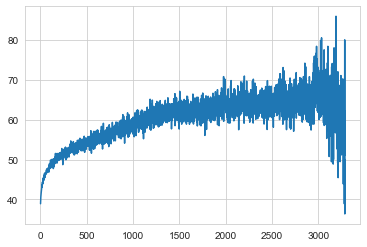

In [111]:
# Cumulative song frequency
train['song_freq'] = train.groupby("song_id")["registration_init_time"].rank("dense")
test['song_freq'] = test.groupby("song_id")["registration_init_time"].rank("dense")

# Plotting the relation between target variable and the song frequency
table = pd.pivot_table(data = train, index = 'song_freq', values = 'song_id', columns = 'target', aggfunc = 'count' )
table = (table.divide(table.sum(axis=1), axis=0))*100
table = table.rename(columns=str).reset_index()
_ = plt.plot(table.song_freq, table['1'])

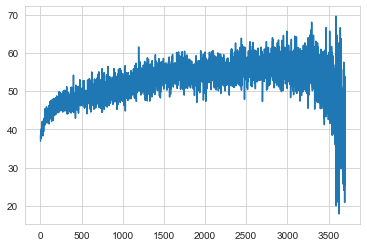

In [112]:
# Cumulative artist frequency
train['artist_freq'] = train.groupby("artist_name")["registration_init_time"].rank("dense")
test['artist_freq'] = test.groupby("artist_name")["registration_init_time"].rank("dense")


# Plotting the relation between target variable and the artist frequency
table = pd.pivot_table(data = train, index = 'artist_freq', values = 'artist_name', columns = 'target', aggfunc = 'count' )
table = (table.divide(table.sum(axis=1), axis=0))*100
table = table.rename(columns=str).reset_index()
_ = plt.plot(table.artist_freq, table['1'])

### Other features on composer and artist

In [113]:
# Feature where composer, artist and lyricist are same
train['composer_artist_lyricist'] = ((train.composer == train.lyricist) & (train.composer == train.artist_name) \
                                    & (train.lyricist == train.artist_name)).astype(np.int8)

test['composer_artist_lyricist'] = ((test.composer == test.lyricist) & (test.composer == test.artist_name) \
                                    & (test.lyricist == test.artist_name)).astype(np.int8)

# Feature where composer and artist are same
train['composer_artist'] = ((train.composer == train.artist_name)).astype(np.int8)
test['composer_artist'] = ((test.composer == test.artist_name)).astype(np.int8)

### Count of song and artist played overall

In [114]:
# Creating dictionary of songs and the number of times that song was played
_dict_count_song_played_train = {k: v for k, v in train['song_id'].value_counts().iteritems()}
_dict_count_song_played_test = {k: v for k, v in test['song_id'].value_counts().iteritems()}

# Function to search and map songs to the count played
def count_song_played(x):
    try:
        return _dict_count_song_played_train[x]
    except KeyError:
        try:
            return _dict_count_song_played_test[x]
        except KeyError:
            return 0
    
# Features created
train['count_song_played'] = train['song_id'].apply(count_song_played).astype(np.int64)
test['count_song_played'] = test['song_id'].apply(count_song_played).astype(np.int64)

In [115]:
# Creating dictionary of artist and the number of times that song was played
_dict_count_artist_played_train = {k: v for k, v in train['artist_name'].value_counts().iteritems()}
_dict_count_artist_played_test = {k: v for k, v in test['artist_name'].value_counts().iteritems()}

# Function to search and map songs to the count played
def count_artist_played(x):
    try:
        return _dict_count_artist_played_train[x]
    except KeyError:
        try:
            return _dict_count_artist_played_test[x]
        except KeyError:
            return 0
    
# Features created
train['count_artist_played'] = train['artist_name'].apply(count_artist_played).astype(np.int64)
test['count_artist_played'] = test['artist_name'].apply(count_artist_played).astype(np.int64)

### Extracting features from datetime columns

In [116]:
# function to extract date time features

def date_features(data):
    
    # Duration of the membership
    data['duration'] = (data.expiration_date - data.registration_init_time)/np.timedelta64(1, 'D')
    
    # Registration and Expiration Year
    data['registration_year'] = data.registration_init_time.dt.year
    data['expiration_year'] = data.expiration_date.dt.year
    
    # Registration and Expiration Month
    data['registration_month'] = data.registration_init_time.dt.month
    data['expiration_month'] = data.expiration_date.dt.month
    
    # Registration and Expiration Day
    data['registration_day'] = data.registration_init_time.dt.day
    data['expiration_day'] = data.expiration_date.dt.day
    
    # Difference between age of member and song age as per isrc year. Base is taken as 2017
    data['age_of_song'] =  data.isrc_year.apply(lambda x: (2017 - x) if x != -1 else -1)
    
    # Dropping Registraion and Expiration column
    #data.drop('registration_init_time', axis = 1, inplace = True)
    #data.drop('expiration_date', axis = 1, inplace = True)
    
    return data

train = date_features(train)
test = date_features(test)

### Extracting feature of Short and Long Duration Song

In [117]:
# Songs <median are short duration and >median are long duration
train['song_type'] = train.song_length.apply(lambda x: "short" if x < 180000 else "long" )
test['song_type'] = test.song_length.apply(lambda x: "short" if x < 180000 else "long" )

### Reducing the memory consumed by the dataset

In [118]:
# measuring the memory usage
mem = train.memory_usage(index=True).sum()
print("Memory consumed by training set  :   {} MB" .format(mem/ 1024**2))

Memory consumed by training set  :   2152.910144805908 MB


In [119]:
#Selecting string columns
cat_names = list(train.select_dtypes(include='object').columns)
cat_names_2 = ['language','city','registered_via']
cat_names.extend(cat_names_2)

#Converting to categories
train[cat_names] = train[cat_names].astype('category')

int_names = list(train.select_dtypes(include='int64').columns)
train[int_names] = train[int_names].astype('int32')

int_8_col = ['target']#, 'isrc_year']
train[int_8_col] = train[int_8_col].astype('int8')

float_names = list(train.select_dtypes(include='float64').columns)
train[float_names] = train[float_names].astype('float32')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 39 columns):
msno                        category
song_id                     category
source_system_tab           category
source_screen_name          category
source_type                 category
target                      int8
song_length                 float32
genre_ids                   category
artist_name                 category
composer                    category
lyricist                    category
language                    category
city                        category
bd                          int32
gender                      category
registered_via              category
registration_init_time      datetime64[ns]
expiration_date             datetime64[ns]
lyricist_count              int32
artist_count                int32
composer_count              int32
genre_count                 int32
isrc_country                category
isrc_year                   int32
song_freq 

### Outlier Analysis

#### Checking the distribution of age.
     - Age has Negative values (-43 and -38)
     - Age has outliers (<14 and >110)
     - Age have values > 1000 as (1030 and 1051)
     - 39.8% of Values have age as 0. Assuming this as missing values. 

count    7.377418e+06
mean     1.753927e+01
std      2.155447e+01
min     -4.300000e+01
25%      0.000000e+00
50%      2.100000e+01
75%      2.900000e+01
max      1.051000e+03
Name: bd, dtype: float64


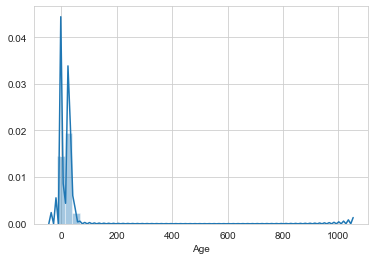

In [120]:
# Distribution of Age
_ = sns.distplot(train.bd, bins = 40)
_ = plt.xlabel("Age")

# Descibing the age in terms of min, max, std values
print(train.bd.describe())

# Note: Same distribution is observed for test dataset also

#### Cleaning Age Column
- Making Negative values as positive values as they are data input error
- (> 1000) values are data input error so subtracting 1000 from such values
- For age between  1 to 13 and >110 considering them as missing values (0)
- Apart from that there are lot of values with age as zero (0). These are mostly missing age values.

In [121]:
# creating function to clean age
def age_clean(age):
    if age < 0: 
        return(abs(age))
    elif age > 1000:
        return(age - 1000)
    elif (age > 0) & (age < 11):
        return 0
    elif (age > 110) & (age < 1000):
        return 0
    else: return age

In [122]:
# Cleaning the age column
train.bd = train.bd.apply(lambda x: age_clean(x))
test.bd = test.bd.apply(lambda x: age_clean(x))

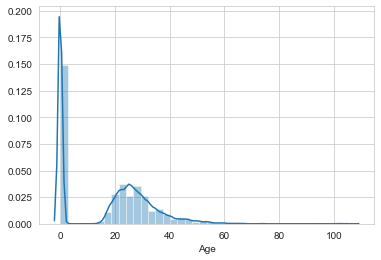

In [123]:
_ = sns.distplot(train.bd, bins = 40)
#_ = sns.distplot(test.bd, bins = 40)
_ = plt.xlabel("Age")

#### Looking out for any outliers in newly created features

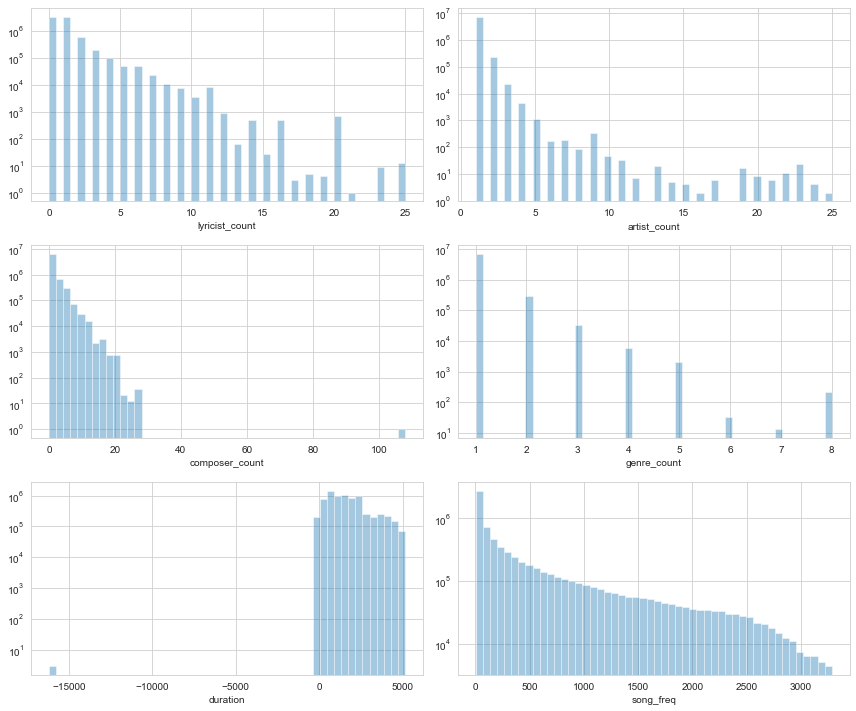

In [124]:
#Plotting existing distribution of Count Variables

# Fixing the figure dimensions and number of subplots
fig_dims = (12, 10)
fig, ax = plt.subplots(nrows = 3, ncols = 2,figsize=fig_dims)

#Plot distribution graphs for different count variables
sns.distplot(train.lyricist_count,kde = False, ax=ax[0][0])
sns.distplot(train.artist_count,kde = False, ax=ax[0][1])
sns.distplot(train.composer_count,kde = False, ax=ax[1][0])
sns.distplot(train.genre_count, kde = False, ax=ax[1][1])
sns.distplot(train.duration,kde = False, ax=ax[2][0])
sns.distplot(train.song_freq,kde = False, ax=ax[2][1])

#Set y-axis to log scale for better visualization
ax[2][0].set_yscale('log')
ax[0][0].set_yscale('log')
ax[0][1].set_yscale('log')
ax[1][0].set_yscale('log')
ax[2][1].set_yscale('log')
ax[1][1].set_yscale('log')

fig.tight_layout()

- Composer count as > 100 is something we need to check and correct
- Duration cannot be negative. This might be due to error in date columns
- Relooked into some of the large values of composer, genre, lyricist and artist counts

In [125]:
#pd.options.display.max_colwidth = 10000

mean_duration = train.duration.mean()

def remove_count_outliers(data):
    
    # Removing composer count outliers
    data.loc[data['composer_count'] > 100, 'composer_count'] = 1
    data.loc[data['composer_count'] > 25, 'composer_count'] = 10
    data.loc[data['composer_count'] > 24, 'composer_count'] = 0

    x = 'Point Break| Adams| B. Adams| B.Adams| Barnett| D. Holmes| D.Barett| D.Barnett| D.Holmes| D.Oliver| G. Stack| G.Stack| G.Stack and J. Newman| G.Trotter| Holmes| J. Newman| J.Newman| NEWMAN| Oliver| Stack| Trotter| and G. Stack'
    data.loc[(data['composer_count'] ==22) & (data['composer'] == x) , 'composer_count'] = 10

    data.loc[(data['composer_count'] ==22), 'composer_count'] = 21
    
    # Removing lyricist count outliers
    data.loc[(data['lyricist_count'] >24), 'lyricist_count'] = 0

    y = 'Point Break| Adams| B. Adams| B.Adams| Barnett| D. Holmes| D.Barett| D.Barnett| D.Holmes| D.Oliver| G. Stack| G.Stack| G.Stack and J. Newman| G.Trotter| J. Newman| J.Newman| NEWMAN| Oliver| Stac| Trotter| and G. Stack'
    data.loc[(data['lyricist_count'] ==21) & (data['lyricist'] == y), 'composer_count'] = 10

    # replacing negative duration with mean duration
    
    data['duration'] = data['duration'].apply(lambda x: mean_duration if x < 0 else x)
    
    return data

train = remove_count_outliers(train)
test = remove_count_outliers(test)

## Exploratory Data Analysis 

In [126]:
mem = train.memory_usage(index=True).sum()
print("Memory consumed by training set  :   {} MB" .format(mem/ 1024**2))

Memory consumed by training set  :   1005.404052734375 MB


### No. of Unique Songs and Members in train and test data set

In [127]:
# Unique users in Train and Test data set
print("User Statistics:")
user_unique_train = train.msno.unique()
user_unique_test = test.msno.unique()
print("No. of Unique users in train:", len(user_unique_train))
print("No. of Unique users in test:", len(user_unique_test))

# Users present in test but absent in training data set
diff_users = set(user_unique_test) - set(user_unique_train)
print("Number of Users present in test but absent in training data:", len(diff_users))
percent_diff_users = round(100 * (len(diff_users)/len(user_unique_test)),1)
print("% of Users present in test but absent in training data:", percent_diff_users,"%")
print("\n")

# Unique Songs in Train and Test data set
print("Song Statistics:")
songs_unique_train = train.song_id.unique()
songs_unique_test = test.song_id.unique()
print("No. of Unique songs in train:", len(songs_unique_train))
print("No. of Unique songs in test:", len(songs_unique_test))

# Users present in test but absent in training data set
diff_songs = set(songs_unique_test) - set(songs_unique_train)
print("Number of Songs present in test but absent in training data:", len(diff_songs))
percent_diff_songs = round(100 * (len(diff_songs)/len(songs_unique_test)),1)
print("% of Songs present in test but absent in training data:", percent_diff_songs,"%")

User Statistics:
No. of Unique users in train: 30755
No. of Unique users in test: 25131
Number of Users present in test but absent in training data: 3648
% of Users present in test but absent in training data: 14.5 %


Song Statistics:
No. of Unique songs in train: 359966
No. of Unique songs in test: 224753
Number of Songs present in test but absent in training data: 59873
% of Songs present in test but absent in training data: 26.6 %


Above statistics shows that we will have to deal with cold start problem.

### Distribution of test and train data
#### Due to inherent time-order between the train and test data set, we see a slight distribution difference between test and train data set. Example: In train, users discovered songs mostly through local library and local playlist. But this changed in test where online playlist preference has increased. This points towards change in user behaviours and makes the problem more complex and challenging

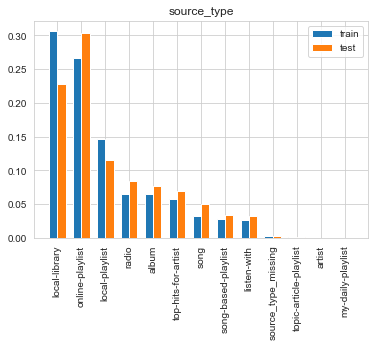

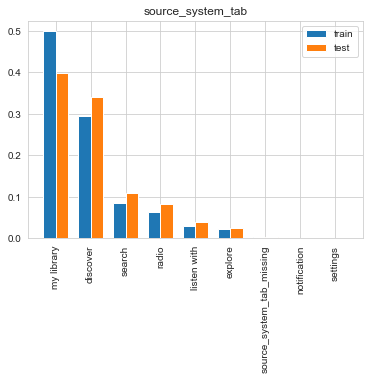

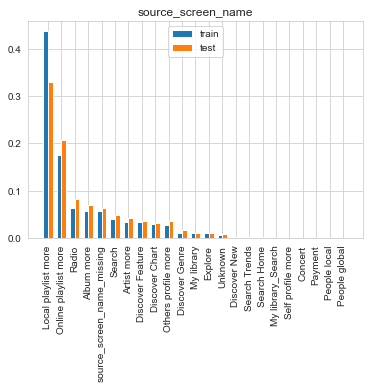

In [128]:
# Defined function to plot train and test data set distribution on single graph
def dist_comp(col,test,train):
    train_col = pd.DataFrame(train[col].value_counts(normalize = True)).reset_index()
    train_col.rename(columns = {col: 'train'}, inplace = True)
    test_col = pd.DataFrame(test[col].value_counts(normalize = True)).reset_index()
    test_col.rename(columns = {col: 'test'}, inplace = True)
    train_col = train_col.merge(test_col, how = 'outer', on = 'index')

    x = np.arange(len(train_col['index'])) 
    barwidth = 0.35

    _ =  plt.bar(x-barwidth/2, train_col.train, width = barwidth, label = 'train')
    _ =  plt.bar(x+barwidth/2, train_col.test, width = barwidth, label = 'test')
    _ =  plt.xticks(ticks = x, labels = train_col['index'], rotation = 90)
    _ = plt.legend()
    _ = plt.title(col)
    plt.show()

dist_comp('source_type', test, train)
dist_comp('source_system_tab', test, train)
dist_comp('source_screen_name', test, train)

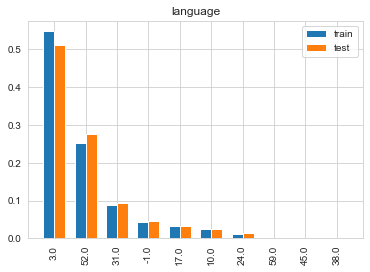

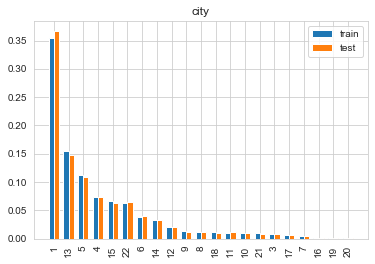

In [129]:
dist_comp('language', test, train)
dist_comp('city', test, train)

### Exploring Source Features

In [130]:
# Defining function to plot and explore categorical features
def plot_dist_target(data,col, labels = False):
    # Grouping required feature and target column
    table = data.groupby([col,'target']).size().unstack()

    #Normalizing i.e Calculating %target
    table = (table.divide(table.sum(axis=1), axis=0))*100

    #Renaming the column index from category to string and sorting based on %
    table = table.rename(columns=str).reset_index()
    table.sort_values('1',ascending = False, inplace = True)
    table = table.reset_index(drop = 'True')

    #Setting Figure size and plotting the bar chart
    fig_dims = (7, 5)
    fig, ax = plt.subplots(figsize=fig_dims)
    
    g = sns.barplot(data = table, x = col,y='1', ax = ax, order = table[col])
    
    if labels == True:
        for index, row in table.iterrows():
            g.text(row.name,row['1'], round(row['1'],0), color='black', ha="center")

    
    plt.ylabel('Target')
    plt.xticks(rotation = 90)
    plt.tight_layout()
    plt.show()

def pie_chart(data,col):
    
    # Setting Figure Dimensions
    fig_dims = (7, 7)
    
    #Creating the base table
    table = pd.DataFrame(data.groupby(col).size())
    table = table.unstack(0)
    table = pd.DataFrame(table, columns = ['count'])
    table = table.droplevel(level = 0)
    #Sorting the table
    table.sort_values('count', ascending = False, inplace = True)
    

    #Plotting a pie chart
    _ = table.plot(y = table.columns, kind='pie',autopct='%1.1f%%', legend = None)

def subplot_dist_target(data,cols,n_rows=1,n_cols=1):
    
    # Defininig the figure dimensions and the subplots
    fig_dims = (15, 6)
    fig, ax = plt.subplots(nrows = n_rows, ncols = n_cols, figsize=fig_dims)

    if n_rows > 1: 
        
        for i,j,col in cols:
            #Grouping Columns
            table = data.groupby([col, 'target']).size().unstack()

            #Normalizing
            table = table.divide(table.sum(axis=1), axis=0)*100

            #Renaming the column index from category to string
            table = table.rename(columns=str).reset_index()
            #table.sort_values('1',ascending = False, inplace = True)

            #Plotting the bar graphs
            chart = sns.barplot(data = table, x = col ,order = table[col], y='1', ax = ax[i,j])#, hue = diag[col])
            chart.set_xticklabels(chart.get_xticklabels(), rotation=60)
            ax[i,j].set_ylabel('Target')
            plt.tight_layout()
    else:
        for i,col in cols:
            
            #Grouping Columns
            table = data.groupby([col, 'target']).size().unstack()

            #Normalizing
            table = table.divide(table.sum(axis=1), axis=0)*100

            #Renaming the column index from category to string
            table = table.rename(columns=str).reset_index()
            #table.sort_values('1',ascending = False, inplace = True)

            #Plotting the bar graphs
            chart = sns.barplot(data = table, x = col ,order = table[col], y='1', ax = ax[i])#, hue = diag[col])
            chart.set_xticklabels(chart.get_xticklabels(), rotation=60)
            ax[i].set_ylabel('Target')
            plt.tight_layout()

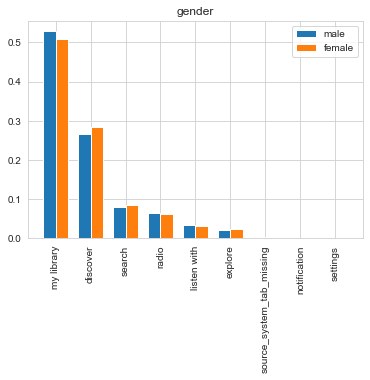

In [131]:
train_col1 = pd.DataFrame(train[train.gender == 'male']['source_system_tab'].value_counts(normalize = True)).reset_index()
#train_col1
train_col1.rename(columns = {'source_system_tab':'male'}, inplace = True)
#train_col1
train_col2 = pd.DataFrame(train[train.gender == 'female']['source_system_tab'].value_counts(normalize = True)).reset_index()
train_col2.rename(columns = {'source_system_tab':'female'}, inplace = True)
train_col = train_col1.merge(train_col2, how = 'outer', on = 'index')

train_col3 = pd.DataFrame(train[train.gender == 'gender_missing']['source_system_tab'].value_counts(normalize = True)).reset_index()
train_col3.rename(columns = {'source_system_tab':'gender_missing'}, inplace = True)
train_col = train_col.merge(train_col3, how = 'outer', on = 'index')

x = np.arange(len(train_col['index'])) 
barwidth = 0.35

_ =  plt.bar(x-barwidth/2, train_col.male, width = barwidth, label = 'male')
_ =  plt.bar(x+barwidth/2, train_col.female, width = barwidth, label = 'female')
_ =  plt.xticks(ticks = x, labels = train_col['index'], rotation = 90)
_ = plt.legend()
_ = plt.title('gender')
plt.show()

#### Source Type: People listening to songs from local playlists, local library and artist have higher chance of being listened again

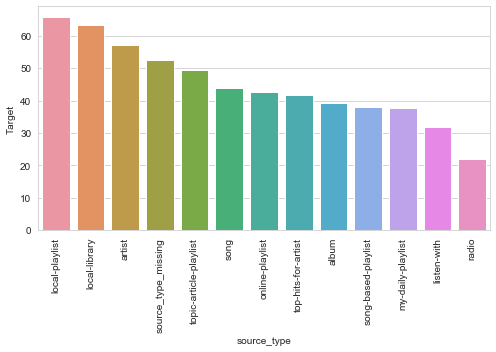

In [132]:
plot_dist_target(train,'source_type')

#### Users prefers to listen from my library tab to listen to their favourite songs in both source screen name and source system tab

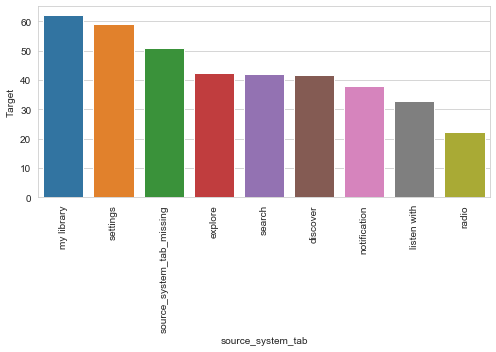

In [133]:
plot_dist_target(train,'source_system_tab')

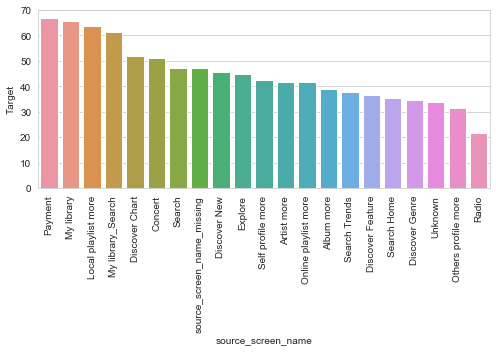

In [134]:
plot_dist_target(train,'source_screen_name')

#### No Correlation between the gender and target value was observed. Missing gender had slighlty lower values. 

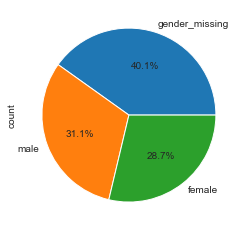

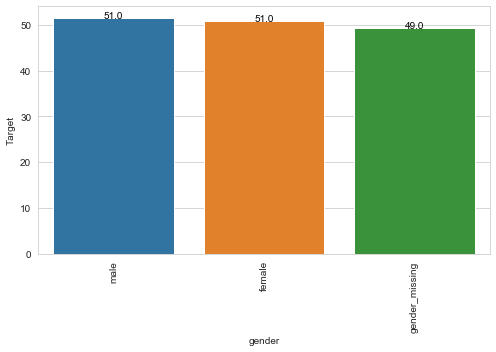

In [135]:
#Distribution of gender
pie_chart(train,'gender')

#Exploring Hospital Readmission Rates
plot_dist_target(train,'gender', labels = True)

#### Two languages dominate the songs, 3 and 52. They make up 80% of the data.

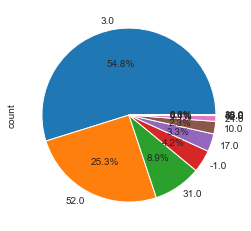

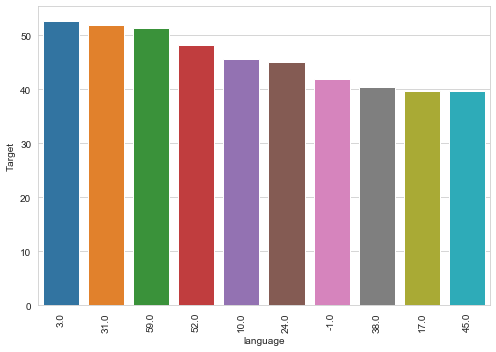

In [136]:
pie_chart(train,'language')
plot_dist_target(train,'language')

#### Cities variable show less correlation with the target in comparison with langauge except for 3 cities, 20, 16 and 19 (less frequent sample)

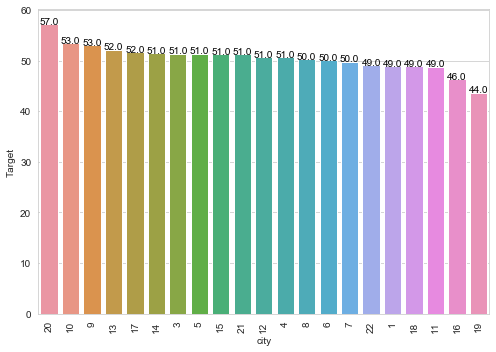

In [137]:
plot_dist_target(train,'city', labels = True)

#### Below table shows that for all cities, two language 3 and 52 dominate uniformly

In [138]:
table = pd.pivot_table(train, values = 'msno', index = 'city', columns = 'language', aggfunc = 'count', fill_value = 0)

#Normalizing i.e Calculating %target
table = round(table.divide(table.sum(axis=1), axis=0)*100)
table

language,-1.0,3.0,10.0,17.0,24.0,31.0,38.0,45.0,52.0,59.0
city,,,,,,,,,,
1,4.0,53.0,3.0,4.0,1.0,9.0,0.0,0.0,26.0,0.0
3,3.0,59.0,2.0,2.0,1.0,9.0,0.0,0.0,24.0,0.0
4,4.0,57.0,2.0,3.0,1.0,8.0,0.0,0.0,24.0,0.0
5,5.0,51.0,2.0,3.0,1.0,9.0,0.0,0.0,29.0,0.0
6,4.0,57.0,3.0,3.0,1.0,8.0,0.0,0.0,24.0,0.0
7,4.0,56.0,2.0,4.0,1.0,10.0,0.0,0.0,23.0,0.0
8,5.0,59.0,2.0,3.0,1.0,7.0,0.0,0.0,23.0,0.0
9,3.0,56.0,2.0,4.0,1.0,9.0,0.0,0.0,25.0,0.0
10,4.0,56.0,2.0,3.0,1.0,10.0,0.0,0.0,24.0,0.0


#### Comparing Language with the isrc country shows, 52 might be english language and 3 might be taiwanes or chinese. 

language,-1.0,3.0,10.0,17.0,24.0,31.0,38.0,45.0,52.0,59.0
isrc_country,,,,,,,,,,
AD,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0
AR,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0
AT,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,0.0
AU,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94.0,0.0
BE,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0
BG,55.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,40.0,0.0
BK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0
BR,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,0.0


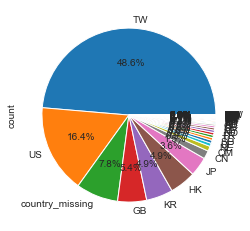

In [139]:
pie_chart(train,'isrc_country')

table = pd.pivot_table(train, values = 'msno', index = 'isrc_country', columns = 'language', aggfunc = 'count', fill_value = 0)

#Normalizing i.e Calculating %target
table = round(table.divide(table.sum(axis=1), axis=0)*100)
table

#### There is not much effect seen on the target with respect to lyricist and composer counts. Number of artist count and genre count seems to have influence on the target variable

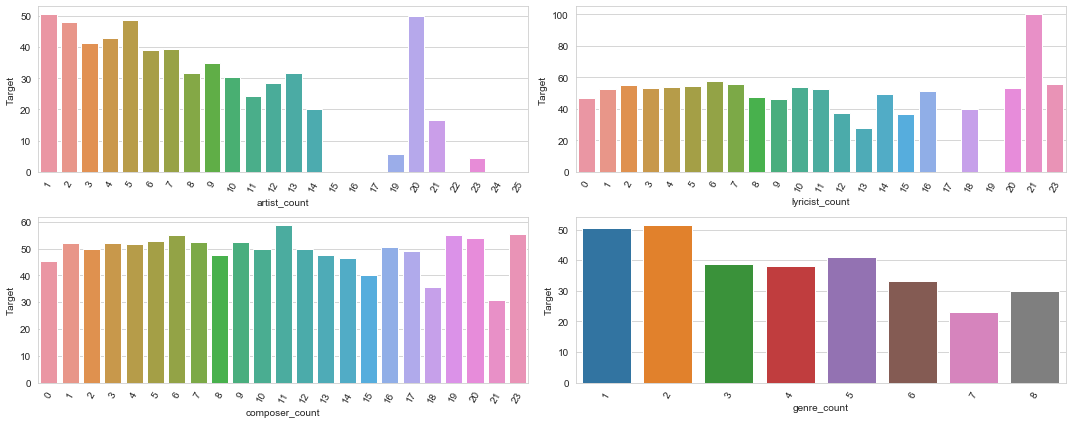

In [140]:
count_col = [(0,0,'artist_count'),(0,1,'lyricist_count'),(1,0,'composer_count'), (1,1,'genre_count')]

subplot_dist_target(train, count_col,n_rows = 2,n_cols = 2)

#### If composer and artist are same, it seems to have influence on the target variables. While if all three are same, there is little variation.

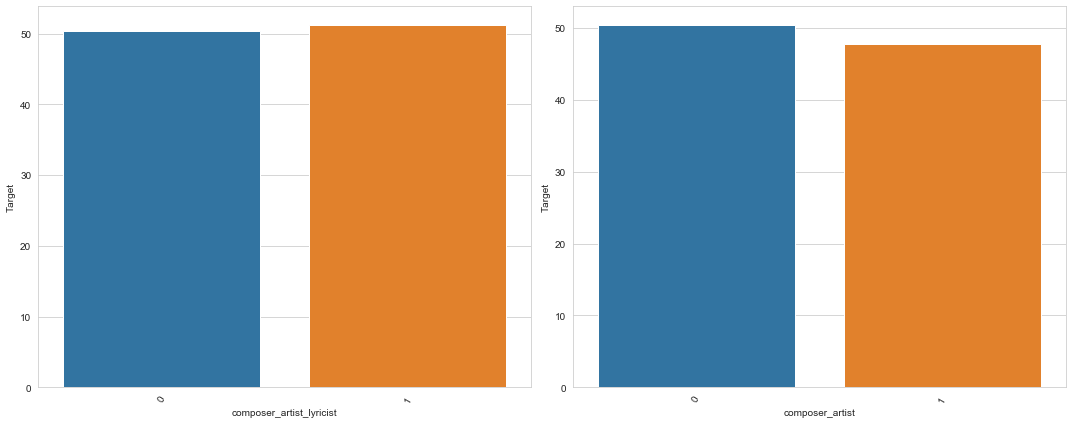

In [141]:
count_col = [(0,'composer_artist_lyricist'),(1,'composer_artist')]

subplot_dist_target(train, count_col,n_cols = 2)

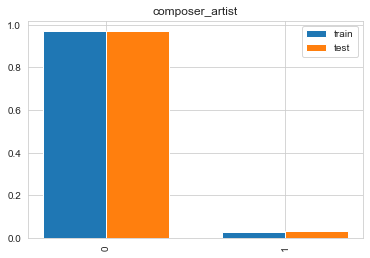

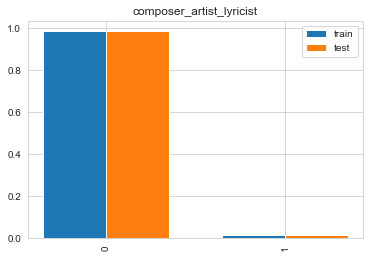

In [142]:
dist_comp('composer_artist', test, train)
dist_comp('composer_artist_lyricist', test, train)

#### Registration Day doesn't seem to have much correlation with the target values. The same is the case with expiration day. Other date features show some correlation with the target variables. 

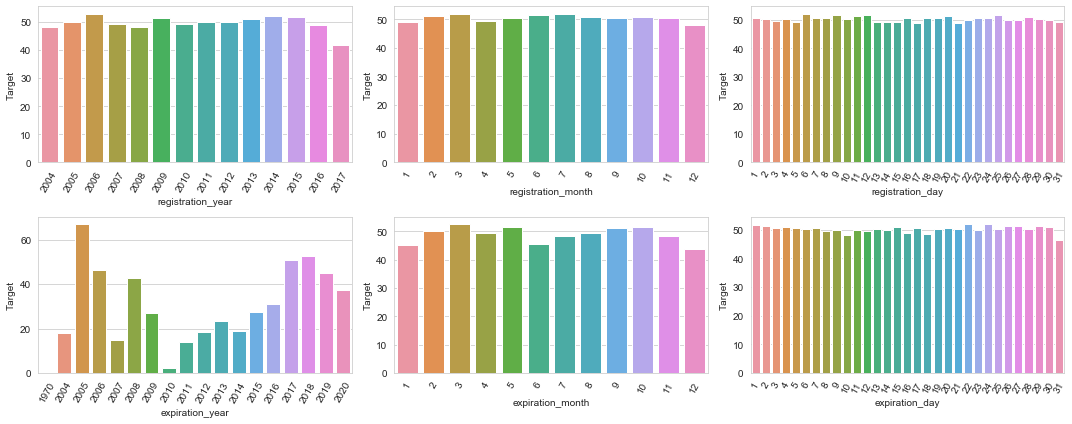

In [143]:
count_col = [(0,0,'registration_year'),(0,1,'registration_month'), (0,2,'registration_day'),
            (1,0,'expiration_year'), (1,1,'expiration_month'),(1,2,'expiration_day')]

subplot_dist_target(train, count_col,n_rows = 2,n_cols = 3)

#### Song length seems to have significant effect on the target variable

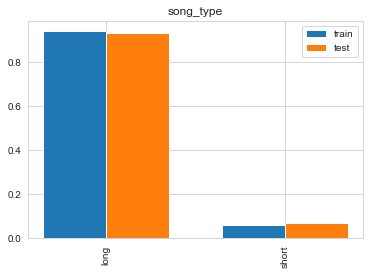

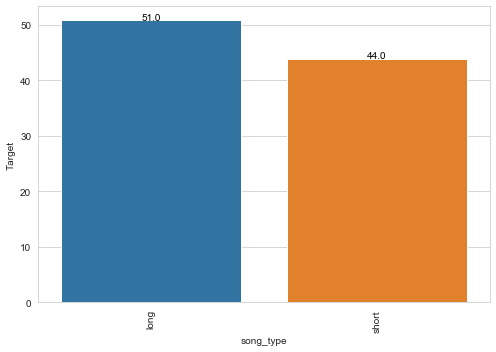

In [144]:
dist_comp('song_type', test, train)
plot_dist_target(train,'song_type', labels = True)

#### Registered_via, only 4 and 13 seems to be the low preference. But the frequency of those categories is also low.

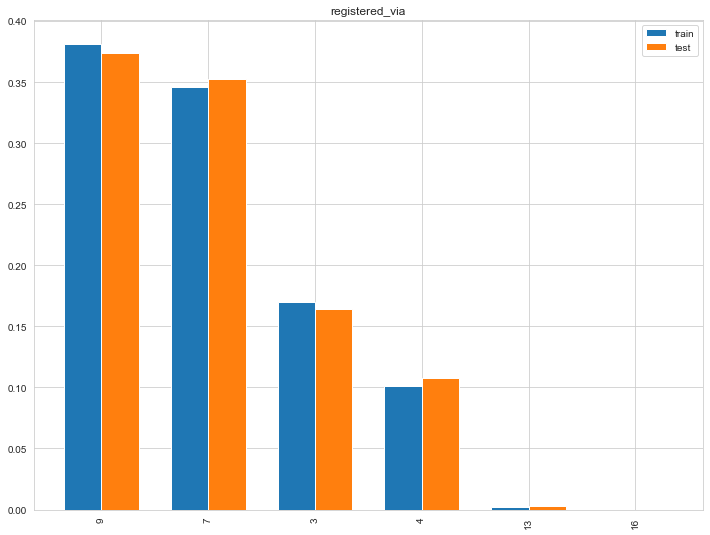

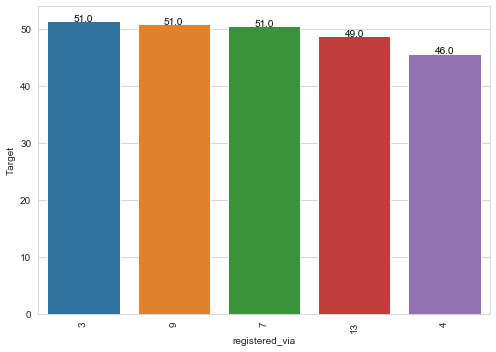

In [170]:
dist_comp('registered_via', test, train)
plot_dist_target(train,'registered_via', labels = True)

#### Age, count_artist_played, age of song, song_freq shows a log_normal distribution. 
#### Count song played, shows different in distribution for repeat listening target variables. Variation is also observed for isrc year (before 1960), song_frequency and age of song.

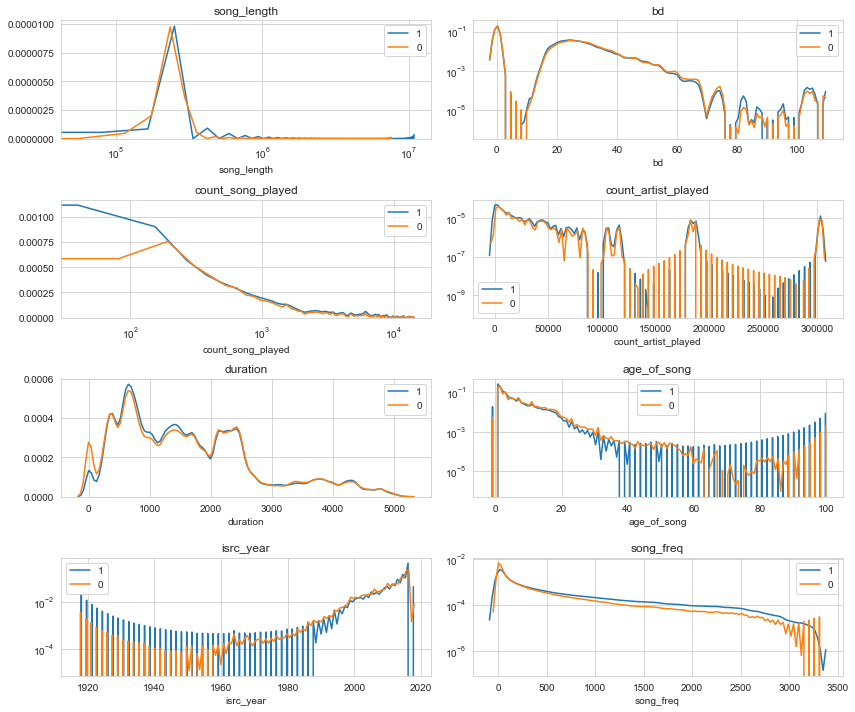

In [164]:
#Checking the distribution of the data set again
figsize(12,10)
 
#Condition whether the readmission is <30 or not
condition1 = train.target == 1

#Selecting only Numeric columns from the df_clean2

numeric_col = ['song_length','bd','count_song_played', 
              'count_artist_played','duration','age_of_song',
              'isrc_year', 'song_freq']
df_numeric = train[numeric_col]

#Making bin size equal to number of unique values in the columns 
bins = [ len(df_numeric.iloc[:,i].unique()) for i in range(len(numeric_col))]


x = [1,2,3,4,5,6,7,8]#,9,10]

#For Loop to plot graphs for all the features together
for i in range(4):
    plt.subplot(4,2, x[2*i])
    plt.title(numeric_col[2*i])
    
    if(numeric_col[2*i] == 'isrc_year'):
        
        sns.distplot(df_numeric[(condition1) & (df_numeric.isrc_year > 0)].iloc[:,2*i], label='1', hist = False)#, histtype = 'stepfilled')
        sns.distplot(df_numeric[(~condition1)& (df_numeric.isrc_year > 0)].iloc[:,2*i], label='0', hist = False)#, histtype = 'stepfilled')
        #plt.hist(df_numeric[condition3].iloc[:,2*i],bins = bins[2*i], alpha = 0.5, label='NO', density = True, histtype = 'stepfilled')
    
    else:
        sns.distplot(df_numeric[condition1].iloc[:,2*i], label='1', hist = False)
        sns.distplot(df_numeric[~condition1].iloc[:,2*i], label='0', hist = False)
        #plt.hist(df_numeric[condition3].iloc[:,2*i],bins = bins[2*i], alpha = 0.5, label='NO', density = True, histtype = 'stepfilled')
    if((numeric_col[2*i] == 'song_length') | (numeric_col[2*i] == 'count_song_played')):
    #    plt.yscale('log')
        plt.xscale('log')
    if((numeric_col[2*i] == 'isrc_year')):
        plt.yscale('log')
    plt.legend()

    plt.subplot(4,2, x[2*i + 1])
    plt.title(numeric_col[2*i + 1])
    sns.distplot(df_numeric[condition1].iloc[:,2*i + 1], label='1', hist = False)
    sns.distplot(df_numeric[~condition1].iloc[:,2*i + 1], label='0', hist = False)
    #plt.hist(df_numeric[condition3].iloc[:,2*i + 1],bins = bins[2*i + 1], alpha = 0.5, label='NO', density = True, histtype = 'stepfilled')
    if((numeric_col[2*i+1] == 'bd') | (numeric_col[2*i+1] == 'count_artist_played') | (numeric_col[2*i+1] == 'age_of_song')
      | (numeric_col[2*i+1] == 'song_freq')):
        plt.yscale('log')    
    #if(numeric_col[2*i+1] == 'number_diagnoses'):
    #    plt.legend(loc = 'upper left')
    #else:
    plt.legend()
    
plt.tight_layout()  


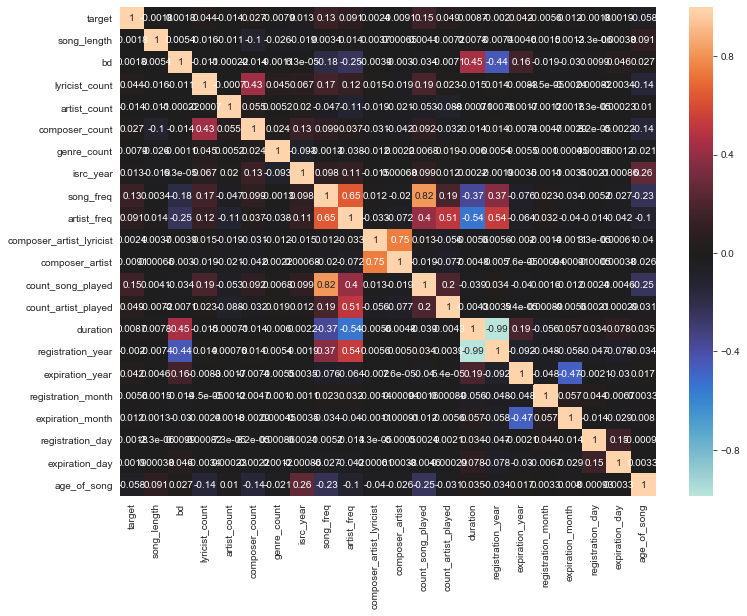

In [168]:
numeric_names = list(train.select_dtypes(exclude='category').columns)
df_vif = train[numeric_names]
corr_matrix = df_vif.corr()
figsize(12,9)
_ = sns.heatmap(corr_matrix, center = 0, annot=True)

In [169]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 39 columns):
msno                        category
song_id                     category
source_system_tab           category
source_screen_name          category
source_type                 category
target                      int8
song_length                 float32
genre_ids                   category
artist_name                 category
composer                    category
lyricist                    category
language                    category
city                        category
bd                          int64
gender                      category
registered_via              category
registration_init_time      datetime64[ns]
expiration_date             datetime64[ns]
lyricist_count              int32
artist_count                int32
composer_count              int32
genre_count                 int32
isrc_country                category
isrc_year                   int32
song_freq 

In [171]:
train.to_csv('train_cleaned.csv',index = False)

In [57]:
class KFoldTargetEncoderTrain(base.BaseEstimator, base.TransformerMixin):

    def __init__(self, colnames,targetName,smoothing=5,n_fold=5,verbosity=True,discardOriginal_col=False):

        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col
        self.smoothing = smoothing

    def fit(self, X, y=None):
        return self


    def transform(self,X):

        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)

        mean_of_target = X[self.targetName].mean()
        
        
        kf = KFold(n_splits = self.n_fold)

        #Naming the column
        col_mean_name = self.colnames + '_' + 'encoded'
        X[col_mean_name] = np.nan

        
        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            #print(tr_ind,val_ind) 
              
            enc = X_tr.groupby(self.colnames)[self.targetName].agg(['count', 'mean'])
            counts = enc['count']
            means = enc['mean']
            smooth = (counts * means + self.smoothing * mean_of_target) / (counts + self.smoothing)

            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].map(smooth)

            X[col_mean_name].fillna(mean_of_target, inplace = True)

        if self.verbosity:

            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'.format(col_mean_name,
                                                                                      self.targetName,
                                                                                      np.corrcoef(X[self.targetName].values, encoded_feature)[0][1]))
        if self.discardOriginal_col:
            X = X.drop(self.colnames, axis=1)
            

        return X

In [58]:
class KFoldTargetEncoderTest(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self,train,colNames,encodedName):
        
        self.train = train
        self.colNames = colNames
        self.encodedName = encodedName
        
        
    def fit(self, X, y=None):
        return self

    def transform(self,X):


        mean = self.train[[self.colNames,self.encodedName]].groupby(self.colNames).mean().reset_index() 
        
        dd = {}
        for index, row in mean.iterrows():
            dd[row[self.colNames]] = row[self.encodedName]

        
        X[self.encodedName] = X[self.colNames]
        X = X.replace({self.encodedName: dd})

        return X

In [59]:
target_encod_col = ['genre_ids', 'composer', 'artist_name', 'lyricist', 'name', 'isrc_country']
train_enc = train
for col in target_encod_col:
    targetc = KFoldTargetEncoderTrain(col,'target',n_fold=5, discardOriginal_col=True )
    train_enc = targetc.fit_transform(train_enc)

Correlation between the new feature, genre_ids_encoded and, target is -0.020212189507638846.
Correlation between the new feature, composer_encoded and, target is 0.10282641674689831.
Correlation between the new feature, artist_name_encoded and, target is 0.10598786848430782.
Correlation between the new feature, lyricist_encoded and, target is 0.07321300876324219.
Correlation between the new feature, name_encoded and, target is 0.13798480358971243.
Correlation between the new feature, isrc_country_encoded and, target is -0.045293406024079434.


In [60]:
drop_col = ['isrc', 'registration_init_time', 'expiration_date', 'song_id']
train_enc = train_enc.drop(drop_col,axis=1)

#Selecting string columns
cat_names = list(train_enc.select_dtypes(include='object').columns)
cat_names_2 = ['language','city','registered_via', 'isrc_year']
cat_names.extend(cat_names_2)

#Converting to categories
train_enc[cat_names] = train_enc[cat_names].astype('category')

int_names = list(train_enc.select_dtypes(include='int64').columns)
train_enc[int_names] = train_enc[int_names].astype('int32')

int_8_col = ['target', 'isrc_year']
train_enc[int_8_col] = train_enc[int_8_col].astype('int8')

float_names = list(train_enc.select_dtypes(include='float64').columns)
train_enc[float_names] = train_enc[float_names].astype('float32')
train_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377415 entries, 0 to 7377417
Data columns (total 37 columns):
msno                        category
source_system_tab           category
source_screen_name          category
source_type                 category
target                      int8
song_length                 float32
language                    category
city                        category
bd                          int32
gender                      category
registered_via              category
lyricist_count              int32
artist_count                int32
composer_count              int32
genre_count                 int32
isrc_year                   int8
duration                    float32
registration_year           int32
registration_month          int32
registration_day            int32
registration_weekday        int32
expiration_year             int32
expiration_month            int32
expiration_day              int32
expiration_weekday          int32
song_freq  

In [61]:
mem = train_enc.memory_usage(index=True).sum()
print("Memory consumed by training set  :   {} MB" .format(mem/ 1024**2))

Memory consumed by training set  :   1172.8017263412476 MB


In [ ]:
#train.to_csv('train_cat.csv',index = False)

In [ ]:
train_enc.head()

In [124]:
#train_enc.to_csv('train_clean.csv',index = False)

### SVD Implementation of User-Song Features

In [62]:
matrix = train.drop(train.columns.difference(['msno','song_id','target']),axis = 1)

n_users = matrix.msno.unique().shape[0]
n_songs = matrix.song_id.unique().shape[0]

users = pd.DataFrame(matrix.msno.unique(), columns = ['msno'])
users['index'] = users.index
users.set_index('msno', inplace = True)
users = users.to_dict()['index']
matrix['msno_index'] =  matrix.msno.map(users)

songs = pd.DataFrame(matrix.song_id.unique(), columns = ['song'])
songs['index'] = songs.index
songs.set_index('song', inplace = True)
songs = songs.to_dict()['index']
matrix['song_index'] =  matrix.song_id.map(songs)

#users = {users.msno: users.index}
matrix= matrix.drop(['msno', 'song_id'], axis = 1)
matrix.head()

,target,msno_index,song_index
0,1,0,0
1,1,1,1
2,1,1,2
3,1,1,3
4,1,0,4


In [63]:
from scipy.sparse import csc_matrix
user_song = csc_matrix((matrix.target, (matrix.msno_index, matrix.song_index)),(n_users,n_songs))
user_song

<30754x359966 sparse matrix of type '<class 'numpy.int64'>'
	with 7377415 stored elements in Compressed Sparse Column format>

In [64]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=15, n_iter=7, random_state=42)
svd.fit(user_song)

TruncatedSVD(algorithm='randomized', n_components=15, n_iter=7, random_state=42,
             tol=0.0)

In [65]:
print(svd.explained_variance_ratio_.sum())
#print(svd.singular_values_)

0.15921303546551016


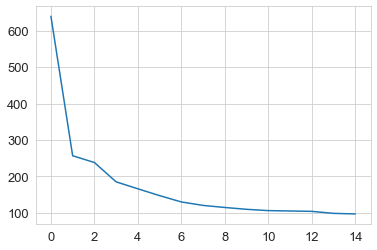

In [66]:
plt.plot(svd.singular_values_)

In [67]:
user_song_reduced = svd.transform(user_song)
col_name = ['us_'+str(i) for i in range(1,16)]
user_song_feat = pd.DataFrame(user_song_reduced, columns = col_name)
user_song_feat['msno'] = train.msno.unique()
#train_enc.any()


train_enc = train_enc.merge(user_song_feat, how = 'left', on = 'msno')
train = train.merge(user_song_feat, how = 'left', on = 'msno')
#train_enc.info()

In [68]:
float_names = list(train_enc.select_dtypes(include='float64').columns)
train_enc[float_names] = train_enc[float_names].astype('float16')
train_enc['duration'] = train_enc['duration'].astype('int32')
train_enc['song_freq'] = train_enc['song_freq'].astype('int32')
#train_enc.drop('msno', axis = 1, inplace = True)
train_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377415 entries, 0 to 7377414
Data columns (total 52 columns):
msno                        object
source_system_tab           category
source_screen_name          category
source_type                 category
target                      int8
song_length                 float32
language                    category
city                        category
bd                          int32
gender                      category
registered_via              category
lyricist_count              int32
artist_count                int32
composer_count              int32
genre_count                 int32
isrc_year                   int8
duration                    int32
registration_year           int32
registration_month          int32
registration_day            int32
registration_weekday        int32
expiration_year             int32
expiration_month            int32
expiration_day              int32
expiration_weekday          int32
song_freq      

### SVD Implementation of User-genre_id Features

In [69]:
matrix = train.drop(train.columns.difference(['msno','genre_ids','target']),axis = 1)
matrix = pd.pivot_table(train,values = 'target', index = 'msno', columns = 'genre_ids', aggfunc= np.sum).fillna(0)
user_genre = csc_matrix(matrix)


0.9679392009596248


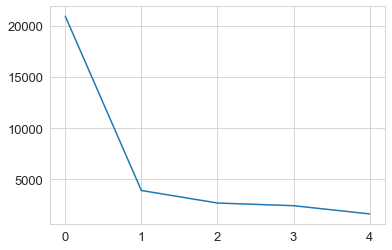

In [70]:
svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
svd.fit(user_genre)
print(svd.explained_variance_ratio_.sum())
plt.plot(svd.singular_values_)

In [71]:
user_genre_reduced = svd.transform(user_genre)
col_name = ['ug_'+str(i) for i in range(1,6)]
user_genre_feat = pd.DataFrame(user_genre_reduced, columns = col_name)
user_genre_feat['msno'] = matrix.index
#train_enc.any()


train_enc = train_enc.merge(user_genre_feat, how = 'left', on = 'msno')
train = train.merge(user_genre_feat, how = 'left', on = 'msno')
#train_enc.info()

In [72]:
#train_enc.info()

### SVD Implementation of User-artist name Features

In [73]:
matrix = train.drop(train.columns.difference(['msno','artist_name','target']),axis = 1)
#matrix = pd.pivot_table(train,values = 'target', index = 'msno', columns = 'artist_name', aggfunc= np.sum).fillna(0)
matrix = matrix.groupby(['msno', 'artist_name'])['target'].sum()
matrix = matrix.reset_index()

n_users = matrix.msno.unique().shape[0]
n_artist = matrix.artist_name.unique().shape[0]

users = pd.DataFrame(matrix.msno.unique(), columns = ['msno'])
users['index'] = users.index
users.set_index('msno', inplace = True)
users = users.to_dict()['index']
matrix['msno_index'] =  matrix.msno.map(users)

artist = pd.DataFrame(matrix.artist_name.unique(), columns = ['artist'])
artist['index'] = artist.index
artist.set_index('artist', inplace = True)
artist = artist.to_dict()['index']
matrix['artist_index'] =  matrix.artist_name.map(artist)

user_index = matrix.msno.unique()
matrix= matrix.drop(['msno', 'artist_name'], axis = 1)
matrix.head()

#user_genre = csc_matrix(matrix)
#matrix.head()

,target,msno_index,artist_index
0,2,0,0
1,1,0,1
2,0,0,2
3,3,0,3
4,4,0,4


0.43740614136199096


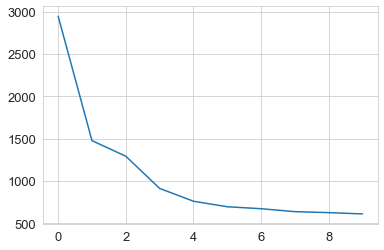

In [74]:
user_artist = csc_matrix((matrix.target, (matrix.msno_index, matrix.artist_index)),(n_users,n_artist))

svd = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
svd.fit(user_artist)
print(svd.explained_variance_ratio_.sum())
plt.plot(svd.singular_values_)

In [75]:
user_artist_reduced = svd.transform(user_artist)
col_name = ['ua_'+str(i) for i in range(1,11)]
user_artist_feat = pd.DataFrame(user_artist_reduced, columns = col_name)
user_artist_feat['msno'] = user_index
#train_enc.any()


train_enc = train_enc.merge(user_artist_feat, how = 'left', on = 'msno')
train = train.merge(user_artist_feat, how = 'left', on = 'msno')
#train_enc.info()

In [76]:
float_names = list(train_enc.select_dtypes(include='float64').columns)
train_enc[float_names] = train_enc[float_names].astype('float16')

float_names = list(train_enc.select_dtypes(include='float32').columns)
float_names.remove('song_length')
train_enc[float_names] = train_enc[float_names].astype('float16')
#train_enc.drop('msno', axis = 1, inplace = True)
train_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377415 entries, 0 to 7377414
Data columns (total 67 columns):
msno                        object
source_system_tab           category
source_screen_name          category
source_type                 category
target                      int8
song_length                 float32
language                    category
city                        category
bd                          int32
gender                      category
registered_via              category
lyricist_count              int32
artist_count                int32
composer_count              int32
genre_count                 int32
isrc_year                   int8
duration                    int32
registration_year           int32
registration_month          int32
registration_day            int32
registration_weekday        int32
expiration_year             int32
expiration_month            int32
expiration_day              int32
expiration_weekday          int32
song_freq      

### SVD Implementation of User- (source_system_tab, source_type, source_screen_name) Features

In [77]:
mixed_feature = pd.Series(train.source_system_tab + " " + train.source_type + " " + train.source_screen_name, name = 'source')
matrix = pd.concat([train.msno, mixed_feature, train.target], axis = 1)


user_source = pd.pivot_table(matrix,values = 'target', index = 'msno', columns = 'source', aggfunc= np.sum).fillna(0)
#matrix = matrix.groupby(['msno', 'artist_name'])['target'].sum()
#matrix = matrix.reset_index()

#n_users = matrix.msno.unique().shape[0]
#n_source = matrix.source.unique().shape[0]

#user_source.head()

0.8115185935467324


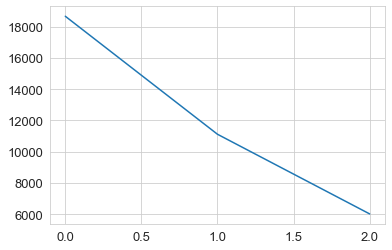

In [78]:
svd = TruncatedSVD(n_components=3, n_iter=7, random_state=42)
svd.fit(user_source)
print(svd.explained_variance_ratio_.sum())
plt.plot(svd.singular_values_)

In [79]:
user_source_reduced = svd.transform(user_source)
col_name = ['usr_'+str(i) for i in range(1,4)]
user_source_feat = pd.DataFrame(user_source_reduced, columns = col_name)
user_source_feat['msno'] = user_source.index
#train_enc.any()


train_enc = train_enc.merge(user_source_feat, how = 'left', on = 'msno')
train = train.merge(user_source_feat, how = 'left', on = 'msno')


#train_enc.info()

In [80]:
float_names = list(train_enc.select_dtypes(include='float64').columns)
train_enc[float_names] = train_enc[float_names].astype('float16')

In [146]:
train_enc.to_csv('train_clean.csv',index = False)

In [46]:
drop_col = ['isrc', 'registration_init_time', 'expiration_date']#, 'song_id', 'msno']
train = train.drop(drop_col,axis=1)

#Selecting string columns
cat_names = list(train.select_dtypes(include='object').columns)
#cat_names_2 = ['language','city','registered_via', 'isrc_year']
#cat_names.extend(cat_names_2)

#Converting to categories
train[cat_names] = train[cat_names].astype('category')

int_names = list(train.select_dtypes(include='int64').columns)
train[int_names] = train[int_names].astype('int16')

int_8_col = ['target', 'isrc_year']
train[int_8_col] = train[int_8_col].astype('uint8')

float_names = list(train.select_dtypes(include='float64').columns)
train[float_names] = train[float_names].astype('float32')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377415 entries, 0 to 7377417
Data columns (total 38 columns):
msno                        category
song_id                     category
source_system_tab           category
source_screen_name          category
source_type                 category
target                      uint8
song_length                 float32
genre_ids                   category
artist_name                 category
composer                    category
lyricist                    category
language                    float32
city                        int16
bd                          int16
gender                      category
registered_via              int16
name                        category
lyricist_count              int16
artist_count                int16
composer_count              int16
genre_count                 int16
isrc_country                category
isrc_year                   uint8
duration                    float32
registration_year           i

In [48]:
#train.to_csv('train_cat.csv',index = False)
train.to_csv('train_study.csv',index = False)

### Exploratory Data Analysis

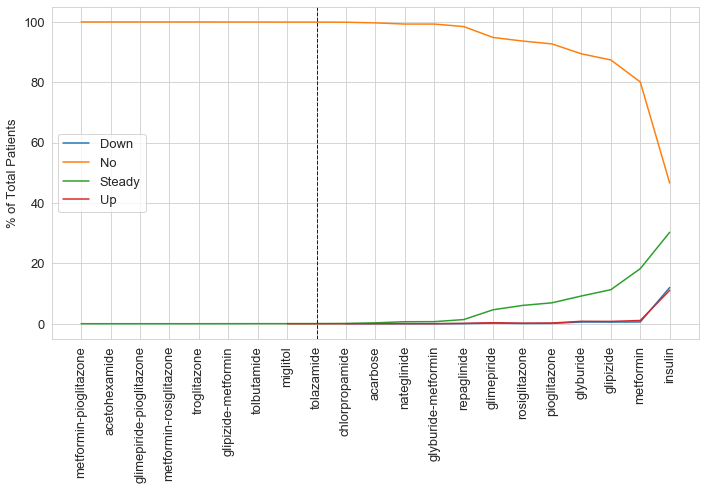

In [78]:
#Extracting 21 features of medicines
med = pd.DataFrame()
x = df_med.drop(['max_glu_serum','A1Cresult','readmitted'], axis = 1)
for col in x.columns:
    med_s = df_med[col].value_counts()
    med = pd.concat([med,med_s],axis = 1) 
med = pd.DataFrame(med.stack())
med = med.unstack(0)
med.columns = med.columns.droplevel(0)
med.sort_values('No',inplace = True, ascending = False)

#Normalizing
med = med.divide(med.sum(axis=1), axis=0)*100

#Plotting the graph
figsize(10,7)
_ = plt.plot(med)
_ = plt.xticks(rotation=90) 
_ = plt.legend(labels = med.columns, loc = 'center left')
_ = plt.axvline(x='tolazamide', color='b', linestyle='dashed', linewidth=1)
_ = plt.ylabel('% of Total Patients')
plt.tight_layout()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  if sys.path[0] == '':


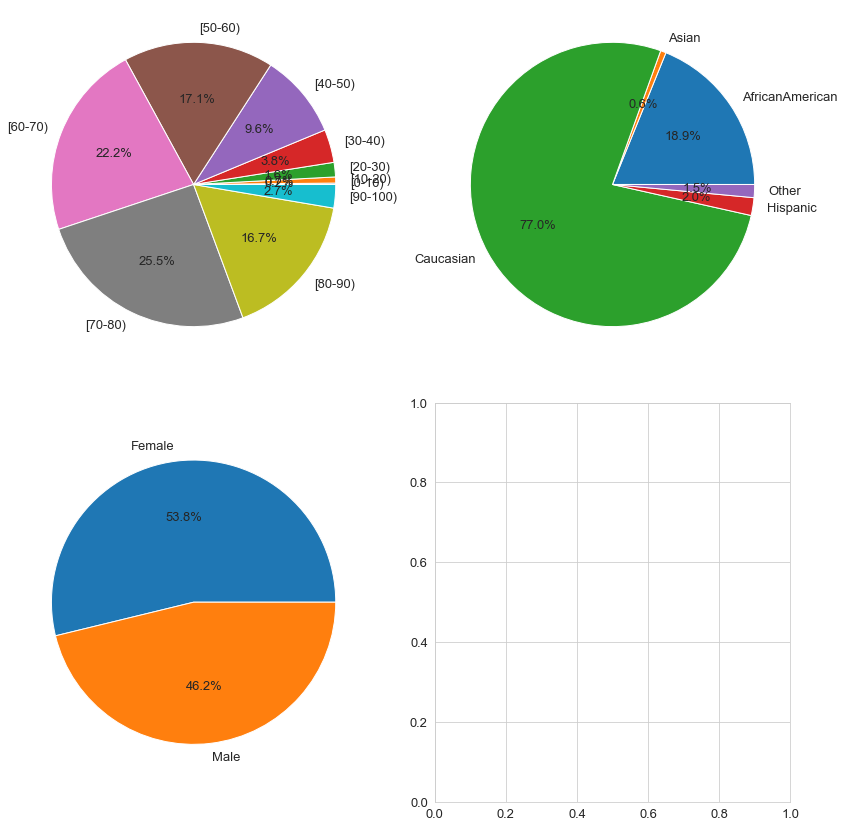

In [79]:
#Extracting relevant Features
age_d = pd.DataFrame(df_clean2.groupby(['age']).size(), columns = ['count'])
race_d = pd.DataFrame(df_clean2.groupby(['race']).size(), columns = ['count'])
gen_d = pd.DataFrame(df_clean2.groupby(['gender']).size(), columns = ['count'])

fig_dims = (12, 12)
fig, axis = plt.subplots(nrows = 2, ncols = 2, figsize=fig_dims)

#Plotting the pie chart to see distribution of categories
axis[0,0].pie(age_d, labels = age_d.index, autopct='%1.1f%%')
axis[0,1].pie(race_d, labels = race_d.index, autopct='%1.1f%%')
axis[1,0].pie(gen_d, labels = gen_d.index, autopct='%1.1f%%')

plt.tight_layout()

#### Checking the Distribution of Race for <30 category of Readmission. Caucasian Race has higher chance of readmission.

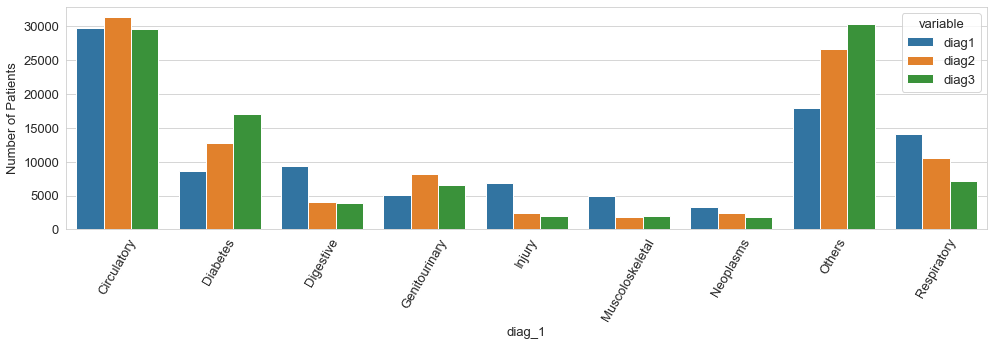

In [85]:
## Grouping all diag columns
diag = pd.DataFrame(df_clean2.groupby(['diag_1']).size(), columns = ['diag1'])
cer2 = dict(df_clean2.groupby(['diag_2']).size(), columns = ['d2'])
cer3 = dict(df_clean2.groupby(['diag_3']).size(), columns = ['d3'])

diag = diag.rename(columns=str).reset_index()

diag['diag2'] = diag.diag_1.map(cer2)
diag['diag3'] = diag.diag_1.map(cer3)
diag = pd.melt(diag, id_vars = ['diag_1'],value_vars = ['diag1','diag2','diag3']).reset_index()

#Plotting the distribution of diagnosis for diag1,diag2 and diag3
fig_dims = (14, 5)
fig, ax = plt.subplots(figsize=fig_dims)

chart = sns.barplot(data = diag, x = 'diag_1',y='value', hue = 'variable' )
chart.set_xticklabels(chart.get_xticklabels(), rotation=60)
ax.set_ylabel('Number of Patients')
plt.tight_layout()

#### Visually exploring to see which numeric variables show difference in distribution readmission (<30) and no readmission (>30, NO)

#### Using Bootstrapped Hypothesis Test to determine statistical signification for above features

#### Performing Chi-square tests on 21 features of Medicines and dependent variable i.e readmitted

In [54]:
#Extracting Column Names
cols = df_med.iloc[:,0:23].columns


#Creating data frame to store results of Chi-Square test for all columns
result = pd.DataFrame(columns = ['Feature','Chi2','Test_stat','Degrees of Freedom'])
result['Feature'] = cols
result = result.set_index('Feature')

#Performing Chi-Square Test for all medicing columns using for loop
for col in cols:
    #Building Contigency Table
    contingency_table = pd.crosstab(df_med.readmitted,df_med[col])
    #print(contingency_table)
    i = contingency_table.shape[1]
    #Converting Contigency Table to array
    f_obs = np.array([contingency_table.iloc[0][0:i].values,
                      contingency_table.iloc[1][0:i].values])
                      #contingency_table.iloc[2][0:i].values])
    #Storing the results
    result['Chi2'].loc[col] = round(stats.chi2_contingency(f_obs)[0],3)
    result['Test_stat'].loc[col] = round(stats.chi2_contingency(f_obs)[1],4)
    result['Degrees of Freedom'].loc[col] = stats.chi2_contingency(f_obs)[2]


result.sort_values('Test_stat',ascending = False, inplace = True)
result

,Chi2,Test_stat,Degrees of Freedom
Feature,,,
metformin-pioglitazone,0.004,0.9497,1
glimepiride-pioglitazone,0.004,0.9497,1
acetohexamide,0.004,0.9497,1
troglitazone,0.012,0.9129,1
nateglinide,1.744,0.6272,3
tolbutamide,0.343,0.5583,1
metformin-rosiglitazone,0.383,0.5357,1
glipizide-metformin,0.614,0.4334,1
glimepiride,3.309,0.3465,3


### Understanding Multi-Collinearity in the independent variables

#### 1) Patient Encounter Variables

([], <a list of 0 Text xticklabel objects>)

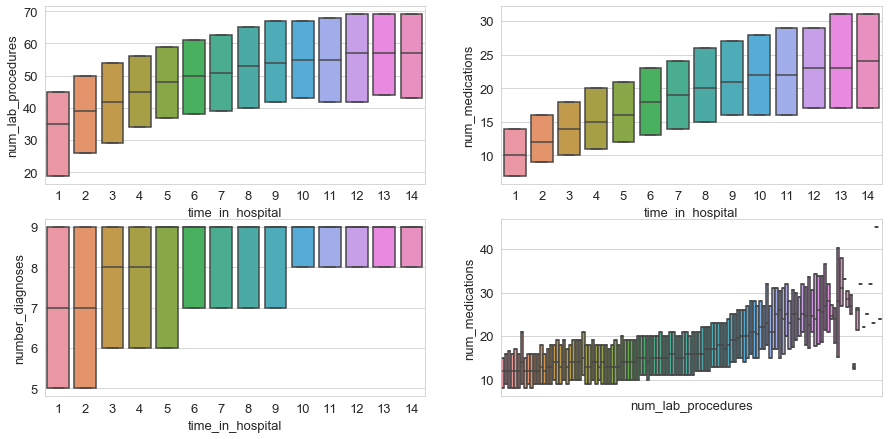

In [89]:
figsize(15,15)

#Plotting box plots without whiskers between various numeric variables
plt.subplot(4,2,1)
sns.boxplot(data = df_clean2, x = 'time_in_hospital', y = 'num_lab_procedures', whis = 0, showfliers=False)

plt.subplot(4,2,2)
sns.boxplot(data = df_clean2, x = 'time_in_hospital', y = 'num_medications',whis = 0, showfliers=False)

plt.subplot(4,2,3)
sns.boxplot(data = df_clean2, x = 'time_in_hospital', y = 'number_diagnoses',whis = 0, showfliers=False)

plt.subplot(4,2,4)
sns.boxplot(data = df_clean2, x = 'num_lab_procedures', y = 'num_medications',whis = 0, showfliers=False)
plt.xticks(ticks = [])

In [90]:
#Verifing the above visual results using Pearson Correlation
y = np.cov(df_clean2.time_in_hospital,df_clean2.num_lab_procedures)
corr, _ = stats.pearsonr(df_clean2.num_medications,df_clean2.time_in_hospital)
print(corr)

0.4640878470768858


#### 2) Patient Admission and discharge Variables

In [91]:
#Building Contigency Table to check multi-collinearity between discharge disposition and admission_type
contingency_table = pd.crosstab(df_clean2.discharge_disposition_id,df_clean2.admission_type_id)
i = contingency_table.shape[1]
#Converting Contigency Table to array
f_obs = np.array([contingency_table.iloc[0][0:i].values,
                  contingency_table.iloc[1][0:i].values,
                  contingency_table.iloc[2][0:i].values,
                  contingency_table.iloc[3][0:i].values,
                  contingency_table.iloc[4][0:i].values])
#Storing the results
stats.chi2_contingency(f_obs)[0:3]


(1999.093880090593, 0.0, 12)

#### 3) Multi-Collinearity between medicine features and change columns

In [93]:
#Extracting Column Names
cols = df_med.iloc[:,0:23].columns

#Creating data frame to store results of Chi-Square test for all columns
result = pd.DataFrame(columns = ['Feature','Chi2','Test_stat','Degrees of Freedom'])
result['Feature'] = cols
result = result.set_index('Feature')

#Performing Chi-Square Test for all medicing columns using for loop
for col in cols:
    #Building Contigency Table
    contingency_table = pd.crosstab(df_clean2.change,df_med[col])
    i = contingency_table.shape[1]
    #Converting Contigency Table to array
    f_obs = np.array([contingency_table.iloc[0][0:i].values,
                      contingency_table.iloc[1][0:i].values])
    #Storing the results
    result['Chi2'].loc[col] = round(stats.chi2_contingency(f_obs)[0],3)
    result['Test_stat'].loc[col] = round(stats.chi2_contingency(f_obs)[1],4)
    result['Degrees of Freedom'].loc[col] = stats.chi2_contingency(f_obs)[2]


result.sort_values('Test_stat',ascending = False, inplace = True)
result

max_glu_serum  >200  >300   None  Norm
change                                
Ch              743   746  44126   826
No              697   465  50760  1747
A1Cresult    >7    >8   None  Norm
change                            
Ch         1925  5315  37014  2187
No         1859  2836  46220  2754
metformin  Down     No  Steady    Up
change                              
Ch          575  30743   14056  1067
No            0  49470    4199     0
repaglinide  Down     No  Steady   Up
change                               
Ch             45  45269    1018  109
No              0  53314     355    0
nateglinide  Down     No  Steady  Up
change                              
Ch             11  45894     512  24
No              0  53521     148   0
chlorpropamide  Down     No  Steady  Up
change                                 
Ch                 1  46411      23   6
No                 0  53614      55   0
glimepiride  Down     No  Steady   Up
change                               
Ch            193  4

,Chi2,Test_stat,Degrees of Freedom
Feature,,,
metformin-pioglitazone,0.005,0.9423,1
glimepiride-pioglitazone,0.005,0.9423,1
acetohexamide,0.005,0.9423,1
tolbutamide,0.011,0.9157,1
tolazamide,1.355,0.5079,2
metformin-rosiglitazone,0.658,0.4172,1
troglitazone,1.646,0.1994,1
glipizide-metformin,6.179,0.0129,1
chlorpropamide,17.054,0.0007,3


In [94]:
df_vif = df_clean2#.drop('readmitted', axis=1)
corr_matrix = df_vif.corr()
figsize(12,9)
_ = sns.heatmap(corr_matrix, center = 0, annot=True)
v

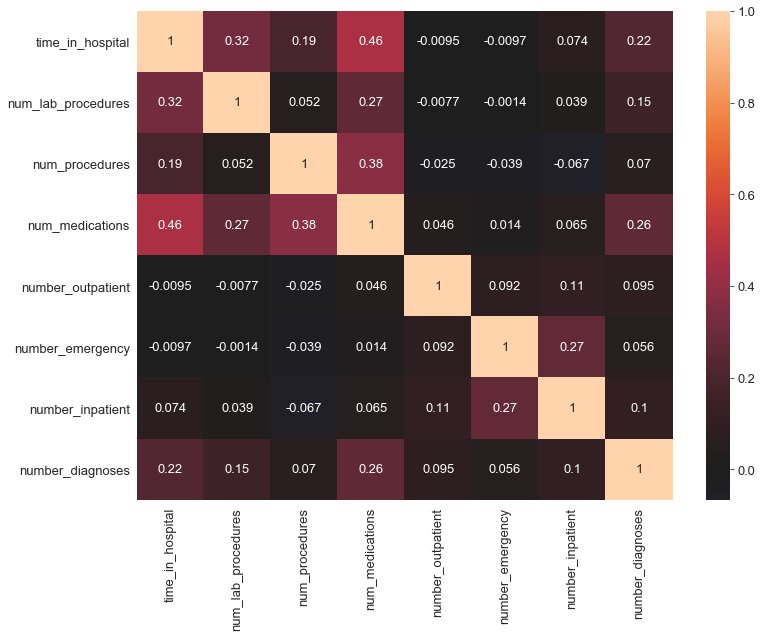

In [95]:
figsize(12,9)
_ = sns.heatmap(corr_matrix, center = 0, annot=True)

In [97]:
df_clean2.shape

(100110, 44)

In [48]:
df_clean2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96551 entries, 0 to 101765
Data columns (total 35 columns):
race                        96551 non-null category
gender                      96551 non-null category
age                         96551 non-null category
admission_type_id           96551 non-null category
discharge_disposition_id    96551 non-null category
admission_source_id         96551 non-null category
time_in_hospital            96551 non-null int64
num_lab_procedures          96551 non-null int64
num_procedures              96551 non-null int64
num_medications             96551 non-null int64
number_outpatient           96551 non-null int64
number_emergency            96551 non-null int64
number_inpatient            96551 non-null int64
diag_1                      96551 non-null category
diag_2                      96551 non-null category
diag_3                      96551 non-null category
number_diagnoses            96551 non-null int64
max_glu_serum               96

In [94]:
#Encoding Age. To retain the ordinal nature of age 
age_dict = {'[70-80)': 75,'[80-90)': 85, '[90-100)':100, '[60-70)': 65, '[50-60)': 55, '[40-50)': 45, '[30-40)':35,
           '[20-30)': 25, '[10-20)': 15, '[0-10)': 5}
df_clean.age = df_clean.age.map(age_dict)

#Visit_num Encoding as Number. '>3' was considered as 4 for simplification purposes
visit_num_dict = {'1.0': 1, '2.0': 2, '3.0': 3, '>3': 4}
df_clean.visit_num = df_clean.visit_num.map(visit_num_dict)


In [95]:
df_numeric_1 = df_clean.select_dtypes(exclude = 'category')
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100110 entries, 0 to 101765
Data columns (total 44 columns):
race                        100110 non-null category
gender                      100110 non-null category
age                         0 non-null float64
admission_type_id           100110 non-null category
discharge_disposition_id    100110 non-null category
admission_source_id         100110 non-null category
time_in_hospital            100110 non-null int64
num_lab_procedures          100110 non-null int64
num_procedures              100110 non-null int64
num_medications             100110 non-null int64
number_outpatient           100110 non-null int64
number_emergency            100110 non-null int64
number_inpatient            100110 non-null int64
diag_1                      100110 non-null category
diag_2                      100110 non-null category
diag_3                      100110 non-null category
number_diagnoses            100110 non-null int64
max_glu_serum     

In [98]:
condition = df_clean.readmitted != 'NO'
df_numeric_2 = df_numeric_1[condition]
condition3 = df_clean.readmitted[condition] != '<30'
numeric_col = ['age','time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency',
      'number_inpatient','number_diagnoses' ,'visit_num']

In [99]:
%%time
#Defining our test statistics 
reps_diff_of_mean = pd.DataFrame(columns = numeric_col)
obs_diff_of_mean = np.empty(shape = 10)

#Loop to calculate P-value for each columns
for i in range(10):
    #Sample for Readmission
    s1 = df_numeric_2[condition3].iloc[:,i]
    n1 = len(s1)
    
    #Sample for Non-Readmission
    s0 = df_numeric_2[~condition3].iloc[:,i]
    n0 = len(s0)

    #Calculating overall mean of the column
    combined_mean = np.mean(df_numeric_2.iloc[:,i])
    
    #Observed difference of mean between two samples
    obs_diff_of_mean[i] = np.mean(s1) - np.mean(s0)

    #Shifting the data for Bootstrapping
    shifted_0 = s0+combined_mean-np.mean(s0)
    shifted_1 = s1+combined_mean-np.mean(s1)

    #Calculating bootstrap replicates
    bs_reps_0 = draw_bs_reps(shifted_0,np.mean,size = N_rep)
    bs_reps_1 = draw_bs_reps(shifted_1,np.mean,size = N_rep)

    #Calculating difference of means for replicates
    reps_diff_of_mean.iloc[:,i] = bs_reps_1 - bs_reps_0
    
    #Calculating p-value
    if obs_diff_of_mean[i] >0:
        p = np.sum(reps_diff_of_mean.iloc[:,i] >= obs_diff_of_mean[i]) / len(reps_diff_of_mean.iloc[:,i])
    else:
        p = np.sum(reps_diff_of_mean.iloc[:,i] <= obs_diff_of_mean[i]) / len(reps_diff_of_mean.iloc[:,i])
    
    print(numeric_col[i], ' p-value =', p*2)
    

age  p-value = 0.0
time_in_hospital  p-value = 0.0
num_lab_procedures  p-value = 0.0635
num_procedures  p-value = 0.0783
num_medications  p-value = 0.0
number_outpatient  p-value = 0.0
number_emergency  p-value = 0.0
number_inpatient  p-value = 0.0
number_diagnoses  p-value = 0.0166
visit_num  p-value = 0.0
Wall time: 3min 16s


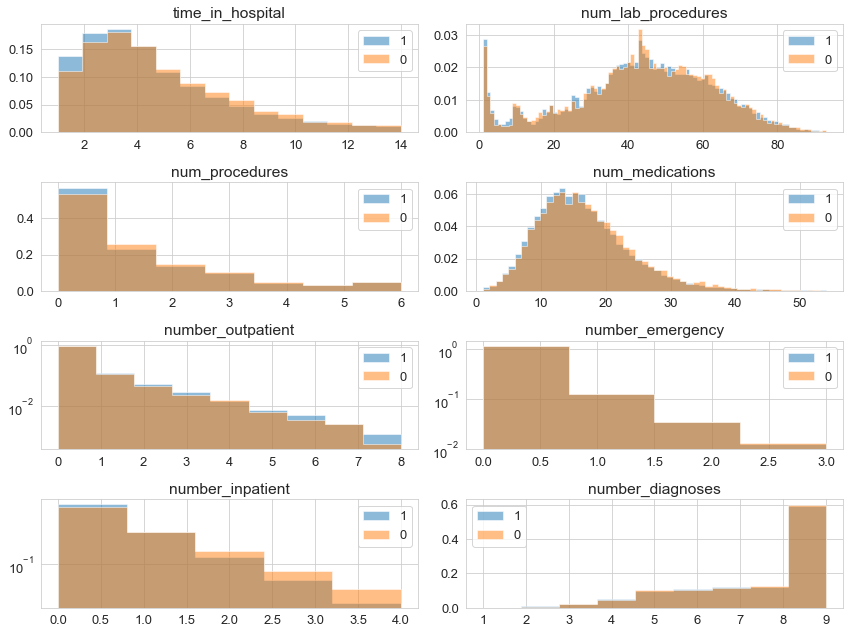

In [67]:
#Making bin size equal to number of unique values in the columns 
bins = [ len(df_numeric_1.iloc[:,i].unique()) for i in range(len(numeric_col))]

x = [1,2,3,4,5,6,7,8]

#For Loop to plot graphs for all the features together
for i in range(4):
    plt.subplot(4,2, x[2*i])
    plt.title(numeric_col[2*i])
    plt.hist(df_numeric_1[condition3].iloc[:,2*i],bins = bins[2*i], alpha = 0.5, label='1', density = True, histtype = 'stepfilled')
    plt.hist(df_numeric_1[~condition3].iloc[:,2*i],bins = bins[2*i], alpha = 0.5, label='0', density = True, histtype = 'stepfilled')
    #plt.hist(df_numeric[condition3].iloc[:,2*i],bins = bins[2*i], alpha = 0.5, label='NO', density = True, histtype = 'stepfilled')
    if((numeric_col[2*i] == 'number_inpatient') | (numeric_col[2*i] == 'number_outpatient') | 
       (numeric_col[2*i] == 'number_emergency')):
        plt.yscale('log')
    plt.legend()

    plt.subplot(4,2, x[2*i + 1])
    plt.title(numeric_col[2*i + 1])
    plt.hist(df_numeric_1[condition3].iloc[:,2*i + 1],bins = bins[2*i + 1], alpha = 0.5, label='1', density = True, histtype = 'stepfilled')
    plt.hist(df_numeric_1[~condition3].iloc[:,2*i + 1],bins = bins[2*i + 1], alpha = 0.5, label='0', density = True, histtype = 'stepfilled')
    #plt.hist(df_numeric[condition3].iloc[:,2*i + 1],bins = bins[2*i + 1], alpha = 0.5, label='NO', density = True, histtype = 'stepfilled')
    if((numeric_col[2*i+1] == 'number_inpatient') | (numeric_col[2*i] == 'number_outpatient') | (numeric_col[2*i] == 'number_emergency')):
        plt.yscale('log')    
    if(numeric_col[2*i+1] == 'number_diagnoses'):
        plt.legend(loc = 'upper left')
    else:
        plt.legend()
    
plt.tight_layout()  